# Part A: Document Clustering

## Importing Libraries

In [1]:
library(tm)
library(SnowballC)

Loading required package: NLP



### Function to read the data and classifying the text, labels and pre-processing the text

In [2]:
eps = 1e-10
  
# read the data
read.data <- function(file.name='Task2A.txt', sample.size=1000, seed=100, pre.proc=TRUE, spr.ratio= 0.90) {
  # INPUTS:
  ## file.name: name of the input .txt file
  ## sample.size: if == 0  reads all docs, otherwise only reads a subset of the corpus
  ## seed: random seed for sampling (read above)
  ## pre.proc: if TRUE performs the preprocessing (recommended)
  ## spr.ratio: is used to reduce the sparcity of data by removing very infrequent words
  # OUTPUTS:
  ## docs: the unlabled corpus (each row is a document)
  ## word.doc.mat: the count matrix (each rows and columns corresponds to words and documents, respectively)
  ## label: the real cluster labels (will be used in visualization/validation and not for clustering)
  
  # Read the data
  text <- readLines(file.name)
  # select a subset of data if sample.size > 0
  if (sample.size>0){
    set.seed(seed)
    text <- text[sample(length(text), sample.size)]
  }
  ## the terms before the first '\t' are the lables (the newsgroup names) and all the remaining text after '\t' are the actual documents
  docs <- strsplit(text, '\t')
  # store the labels for evaluation
  labels <-  unlist(lapply(docs, function(x) x[1]))
  # store the unlabeled texts    
  docs <- data.frame(doc_id=1:length(docs),text=unlist(lapply(docs, function(x) x[2])))

  library(tm)
  # create a corpus
  docs <- DataframeSource(docs)
  corp <- Corpus(docs)
  
  # Preprocessing:
  if (pre.proc){
    corp <- tm_map(corp, removeWords, stopwords("english")) # remove stop words (the most common word in a language that can be find in any document)
    corp <- tm_map(corp, removePunctuation) # remove pnctuation
    corp <- tm_map(corp, stemDocument) # perform stemming (reducing inflected and derived words to their root form)
    corp <- tm_map(corp, removeNumbers) # remove all numbers
    corp <- tm_map(corp, stripWhitespace) # remove redundant spaces 
  }  
  # Create a matrix which its rows are the documents and colomns are the words. 
  dtm <- DocumentTermMatrix(corp)
  ## reduce the sparcity of out dtm
  dtm <- removeSparseTerms(dtm, spr.ratio)
  ## convert dtm to a matrix
  word.doc.mat <- t(as.matrix(dtm))
  
                                   
  # Return the result
  return (list("docs" = docs, "word.doc.mat"= word.doc.mat, "labels" = labels))
}

### Maximising the function

In [3]:
#maximising function that is required to classify the documents into a clusters in a better way
logSum <- function(v) {
   m = max(v)
   return ( m + log(sum(exp(v-m))))
}

### Initializing the required parameters

In [4]:
#initialize the parameters namely rho, mu.
#rho is the parameter which assumes all the clusters is having the same size.
#mu is the parameter that determines probability of each word in a cluster.
#we will update the values of rho, mu later on.
#values of rho,mu are stored randomly with respective rows and columns size.
initial.param <- function(vocab_size, K=4, seed=123456){
  rho <- matrix(1/K,nrow = K, ncol=1)  
  mu <- matrix(runif(K*vocab_size),nrow = K, ncol = vocab_size)     
  mu <- prop.table(mu, margin = 1)     
  return (list("rho" = rho, "mu"= mu))
}

## Expectation step for soft EM

In [5]:
E.step.soft <- function(gamma, model, counts){
    N <- dim(counts)[2] # number of documents
    K <- dim(model$mu)[1]
    for (n in 1:N){
        for (k in 1:K){
            
            ## calculate the posterior based on the estimated mu and rho in the "log space"
            gamma[n,k] <- log(model$rho[k,1]) +  sum(counts[,n] * log(model$mu[k,])) 
        }
        # normalisation to sum to 1 in the log space
        logZ = logSum(gamma[n,])
        gamma[n,] = gamma[n,] - logZ
     }
    # converting back from the log space 
    gamma <- exp(gamma)
    return (gamma)
}

## Expectation step for Hard EM

In [6]:
E.step <- function(gamma, model, counts){
    N <- dim(counts)[2] # number of documents
    K <- dim(model$mu)[1]
    for (n in 1:N){
        for (k in 1:K){
            
            ## calculate the posterior based on the estimated mu and rho in the "log space"
            gamma[n,k] <- log(model$rho[k,1]) +  sum(counts[,n] * log(model$mu[k,])) 
        }
        # normalisation to sum to 1 in the log space
        logZ = logSum(gamma[n,])
        gamma[n,] = gamma[n,] - logZ
    }
    
    #as it is the HardEM and document belongs to only one cluster, we get the max probability of the document belonging to a cluster among all clusters
    #after getting which cluster has the maximum probability, make the document belonging to particular cluster as 1 and remaining as 0
    
    max.prob <- gamma == apply(gamma, 1, max) 
    gamma[max.prob] <- 1 
    gamma[!max.prob] <- 0 
    # converting back from the log space 
    gamma <- exp(gamma)
    return (gamma)
}

## Maximising step for Hard EM, Soft EM

1. The maximising step for both Hard EM and Soft EM is same. 

2. Initially, we will take all the cluster sizes as same , now we will update the cluster sizes and store it in a phi parameter.

3. Later we will calculate the probability of each word in a cluster for a document using the formula for mu, which we obtained in first part of the question. 

4. In order to prevent NaN for the vectors where all the elements are zero, eps value is added in the numerator and denominator, where that value is declared intially.

5. Normalize mu to 1 using prop table.

In [7]:
##--- M Step for Document Clustering  --------------------------------------------
M.step <- function(gamma, model, counts){
  # Model Parameter Setting
  N <- dim(counts)[2]   # number of documents
  W <- dim(counts)[1]   # number of words i.e. vocabulary size
  K <- dim(model$mu)[1] # number of clusters
 
  #get intial cluster sizes and store it in a variable phi.hat, which needs to get updates.
  phi.hat <- model$rho
  for (k in 1:K){
      
      ## recalculate the estimations:
    phi.hat[k] <- sum(gamma[,k])/N     # the relative cluster size
    
}
  model$rho <- phi.hat
  for (k in 1:K){
      for (w in 1:W){
          numerator <- sum(gamma[,k] * counts[w,]) + eps
          denominator <- sum(gamma[,k] * counts) 
          maximised_value <- numerator / (denominator + K * eps)
          model$mu[k,w] <- maximised_value
      }
  }
    
  model$mu <- prop.table(model$mu, margin = 1) #standardize to 1. 
  # Return the result
  return (model)
}

### Calling the EM function, which here by calls expectation and maximisation step.

In [8]:
EM <- function(counts, K=4, max.epoch=10, seed=123456, type){
  #INPUTS:
  ## counts: word count matrix
  ## K: the number of clusters
  #OUTPUTS:
  ## model: a list of model parameters
  
  # Model Parameter Setting
  N <- dim(counts)[2] # number of documents
  W <- dim(counts)[1] # number of unique words (in all documents)
  
  # Initialization
  model <- initial.param(W, K=K, seed=seed)
  gamma <- matrix(0, nrow = N, ncol = K)

  #if the type of clustering we want to do is "Hard EM", run the below snippet of code.
  if(type == "Hard EM"){
      
      for(epoch in 1:max.epoch){
          
          gamma <- E.step(gamma, model, counts)
          model <- M.step(gamma, model, counts)
    }
      return(list("model"=model,"gamma"=gamma))
  }
 
  #if the type of clustering we want to do is "SOft EM", run the below snippet of code.
  if(type == "Soft EM"){
      
      for(epoch in 1:max.epoch){
          
          gamma <- E.step.soft(gamma, model, counts)
          model <- M.step(gamma, model, counts)
    }
      return(list("model"=model,"gamma"=gamma))
  }
    
}

### Training Objective function

In [9]:
##--- the training objective function --------------------------------------------
# Input: 
#    model:  the model object containing the mu and rho
#    counts: the word-document frequency matrix
# Output:
#    nloglike: the negative log-likelihood i.e. log P(counts|model) 
#   
train_obj <- function(model, counts) { 
  N <- dim(counts)[2] # number of documents
  K <- dim(model$mu)[1]
   
  nloglike = 0
  for (n in 1:N){
    lprob <- matrix(0,ncol = 1, nrow=K)
    for (k in 1:K){
      lprob[k,1] = sum(counts[,n] * log(model$mu[k,])) 
    }
    nloglike <- nloglike - logSum(lprob + log(model$rho))
  }
  
  return (nloglike)
}


### Cluster Visualization

In [10]:
##--- Cluster Visualization -------------------------------------------------
cluster.viz <- function(doc.word.mat, color.vector, title=' '){
  p.comp <- prcomp(doc.word.mat, scale. = TRUE, center = TRUE)
  plot(p.comp$x, col=color.vector, pch=1,  main=title)
}

In [11]:
#read the data
data <- read.data(file.name='Task2A.txt', sample.size=0, seed=100, pre.proc=TRUE, spr.ratio= .99)
#word-document frequency matrix
counts <- data$word.doc.mat   

### Calling EM step for hard and soft EM

In [12]:
options(warn = -1)
res_hardEM <- EM(counts, K=4, max.epoch=5, 123456, "Hard EM") 
res_softEM <- EM(counts, K=4, max.epoch=5, 123456, "Soft EM") 

### Visualizing Hard EM

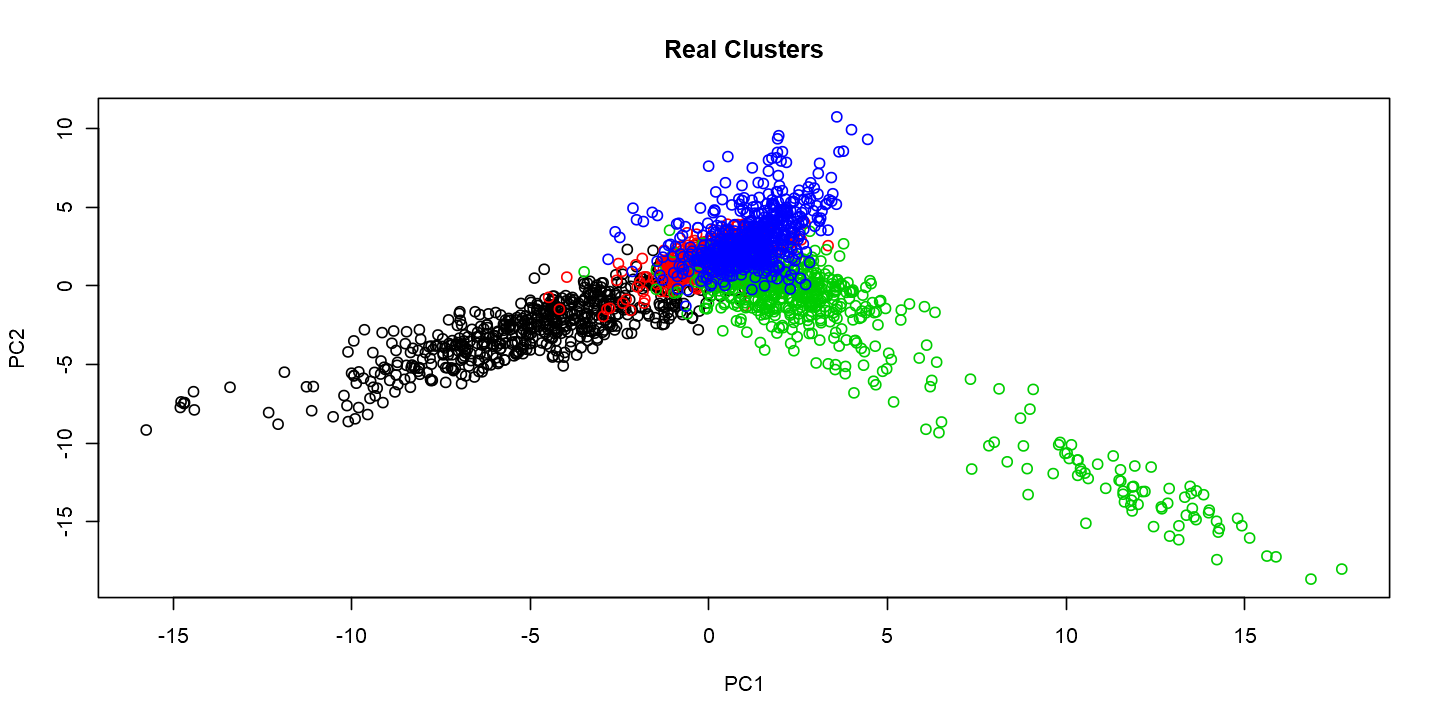

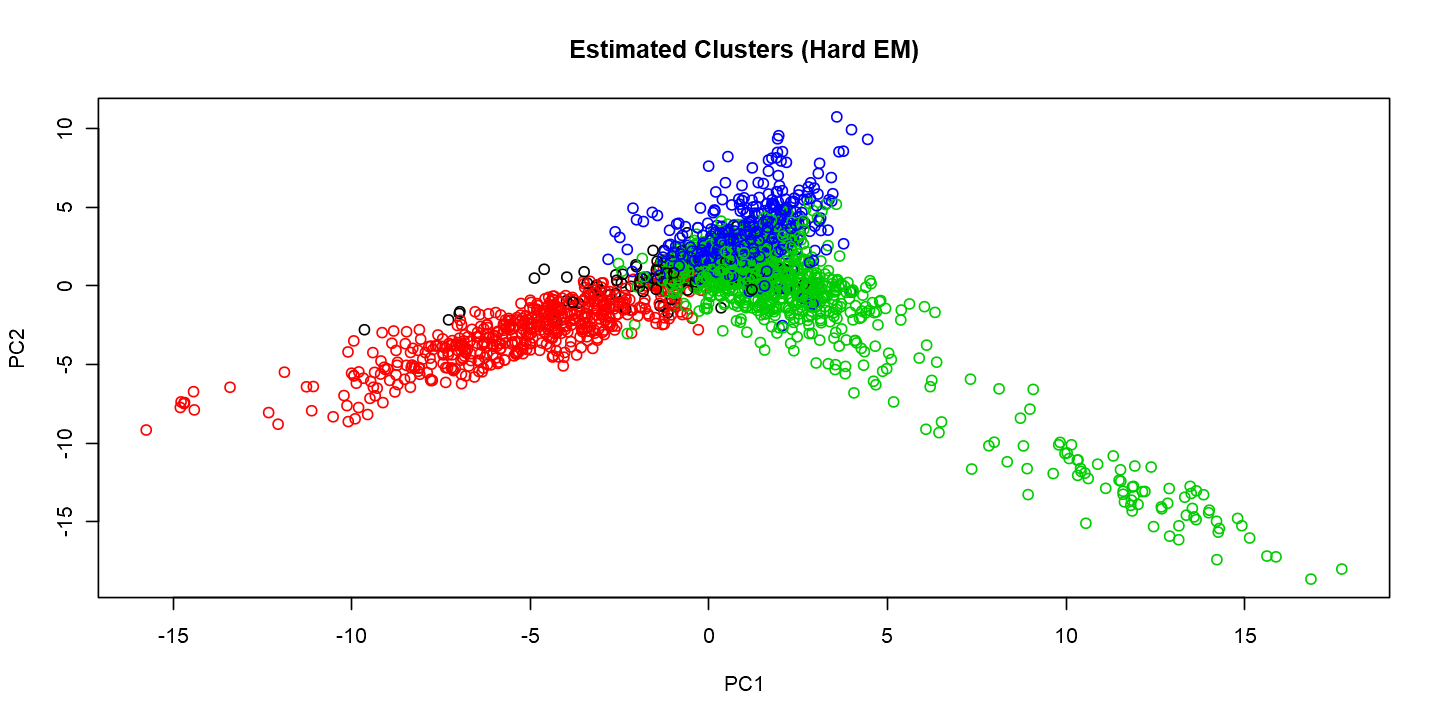

In [13]:
options(repr.plot.width = 12, repr.plot.height = 6)
# find the culster with the maximum probability 
label.hat <- apply(res_hardEM$gamma, 1, which.max) 
#normalize the count matrix for better visualization
counts<-scale(counts) 
# visualize the real clusters
cluster.viz(t(counts), factor(data$label), 'Real Clusters')
#visualize the Hard EM clusters
cluster.viz(t(counts), label.hat, 'Estimated Clusters (Hard EM)')

### Visualizing Soft EM

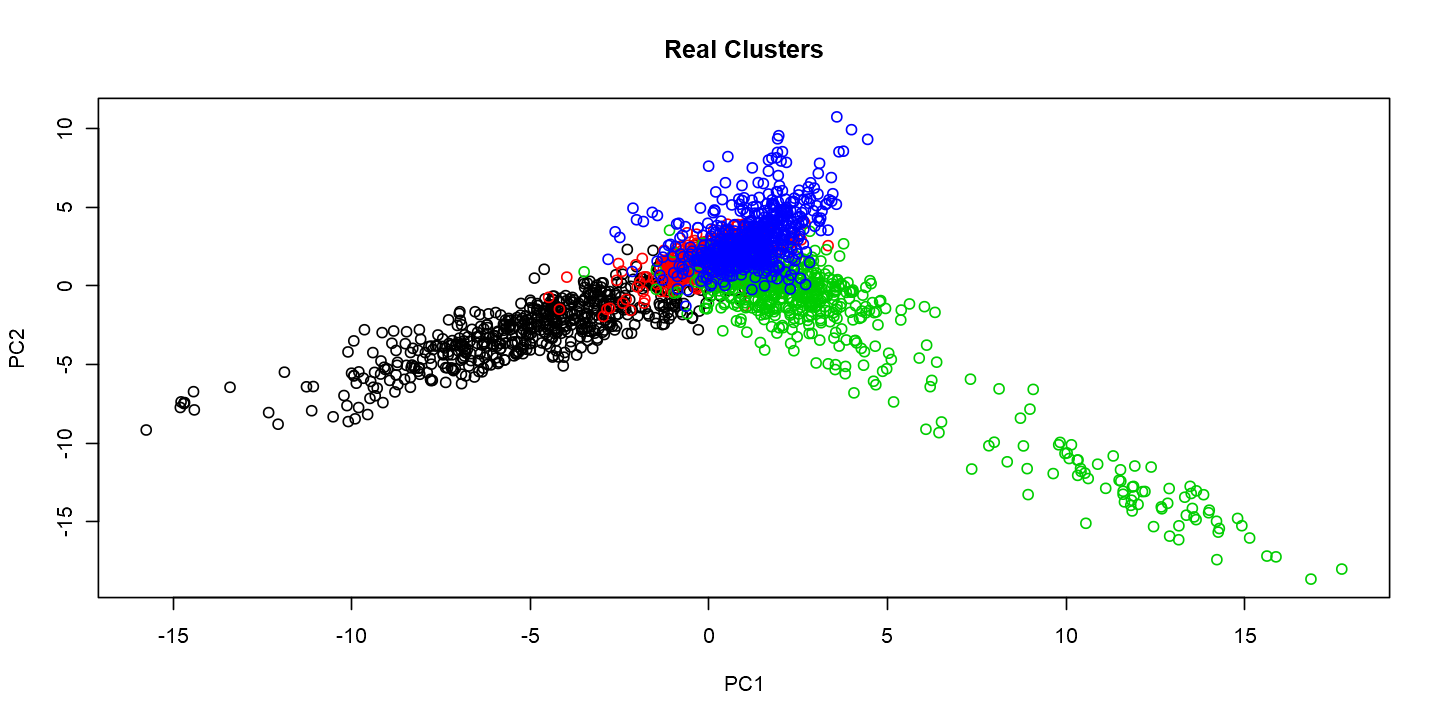

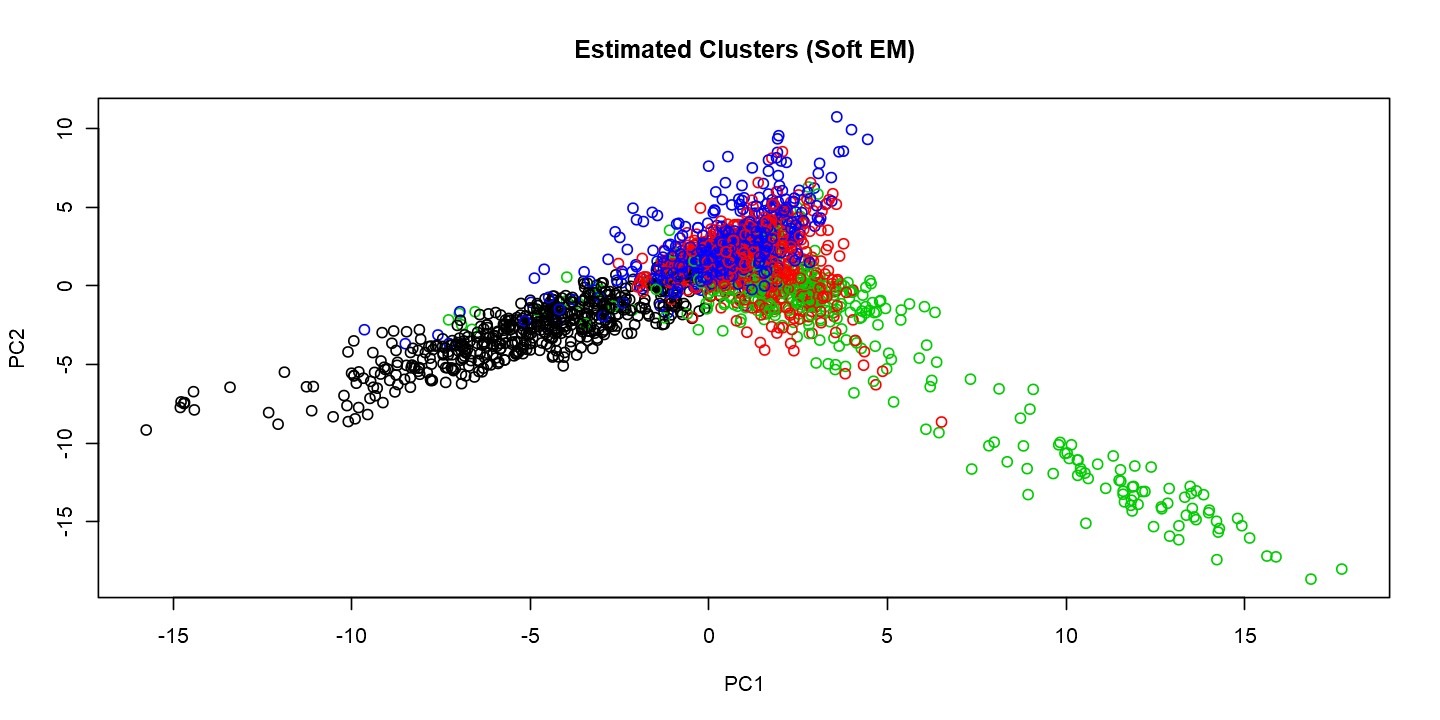

In [14]:
options(repr.plot.width = 12, repr.plot.height = 6)
# find the culster with the maximum probability 
label.hat <- apply(res_softEM$gamma, 1, which.max)
#normalize the count matrix for better visualization
counts<-scale(counts) 
# visualize the real clusters
cluster.viz(t(counts), factor(data$label), 'Real Clusters')
#visualize the softEM clusters
cluster.viz(t(counts), label.hat, 'Estimated Clusters (Soft EM)')